# Quick Start

In quick start, we will explore:

- a forecast task on iclaims dataset
- a simple Bayesian ETS Model using `PyStan`
- tools to visualize the forecast

## Library

In [20]:
from orbit.utils.dataset import load_iclaims
from orbit.models.dlt import ETSFull
from orbit.diagnostics.plot import plot_predicted_data

## Data

*iclaims_example* is a dataset containing the weekly initial claims for US unemployment benefits against a few related google trend queries (unemploy, filling and job)from Jan 2010 - June 2018. 
This aims to mimick the dataset from the paper [Predicting the Present with Bayesian Structural Time Series](https://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf) by SCOTT and VARIAN (2014).

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while regressors such as google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).
Note that dataset is transformed by natural log before fitting in order to be fitted as a multiplicative model.  We will continue to use this dataset in some subsequent sections.

In [6]:
# load data
df = load_iclaims()
date_col = 'week'
response_col = 'claims'
df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [7]:
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


### Train / Test Split

In [8]:
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]

## Forecasting Using Orbit

`Orbit` aims to provide an intuitive **initialize-fit-predict** interface for working with forecasting tasks. Under the hood, it is utilizing probabilistic modeling API such as
`PyStan` and `Pyro`. We first illustrate a Bayesian implementation of Rob Hyndman's ETS (which stands for Error, Trend, and Seasonality) Model [(Hyndman et. al, 2008)](http://www.exponentialsmoothing.net/home) using `PyStan`.

In [21]:
dlt = ETSFull(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

In [22]:
%%time
dlt.fit(df=train_df)

CPU times: user 285 ms, sys: 70.2 ms, total: 356 ms
Wall time: 1.46 s


In [23]:
predicted_df = dlt.predict(df=test_df)

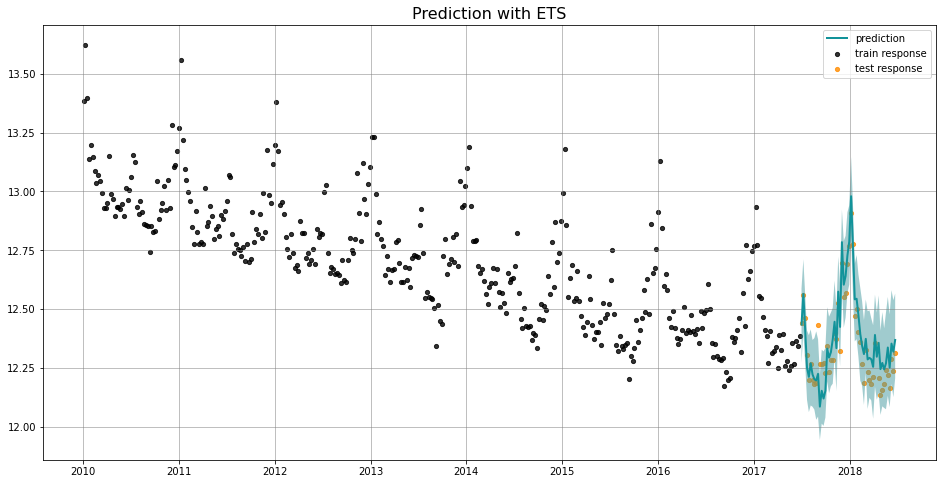

In [24]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=date_col, actual_col=response_col,  
                    test_actual_df=test_df, title='Prediction with ETS')